In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
import os
os.chdir("/content/gdrive/My Drive/CS498DL/CS498DL-project/cases")

Mounted at /content/gdrive


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define neural network

In [ ]:
# Model
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self, nof=50, dim=2, num_layers=4):
        super().__init__()
        self.dim = dim
        self.input_layer = nn.Linear(dim, nof)
        
        def f():
          return nn.Sequential(nn.Linear(nof, nof), nn.Tanh())
        self.hidden_layer = nn.Sequential(
            *[f() for _ in range(num_layers)],
        )
        self.output_layer = nn.Linear(nof, 1)


    def forward(self, x, y):
        input = torch.cat((x, y), dim=-1)
        input = torch.tanh(self.input_layer(input))
        input = self.hidden_layer(input)
        input = self.output_layer(input)
        return input

# Initialize data and forcing function

In [ ]:
# Initialize data
gridsize = 100
x = torch.linspace(0, 1, gridsize, device=device)
X, Y = torch.meshgrid(x, x)
X = X.to(device)
Y = Y.to(device)
f = torch.zeros_like(X)

# load f data into torch
X = X.reshape((-1, gridsize, 1))
Y = Y.reshape((-1, gridsize, 1))
f = f.reshape((-1, gridsize, 1)).to(device)
Xc = X.clone().to(device)
Xc.requires_grad = True
Yc = Y.clone().to(device)
Yc.requires_grad = True

# load BC data into torch
bound_left = 0.0
bound_right = 0.0
bound_bottom = 0.0
bound_top = 0.0
bound_slope_top = np.pi * (np.exp(np.pi) + np.exp(-np.pi)) * torch.sin(np.pi * x)

def plot(*args):
  return map(lambda x : x.cpu().detach().numpy(), args)


# Loss functions for different pdes

In [ ]:
# loss functions
def pde_loss_poisson(pred, x, y, f, lambda_pde):
    du_dx = torch.autograd.grad(pred.sum(), x, create_graph=True)[0]
    du2_dx2 = torch.autograd.grad(du_dx.sum(), x, create_graph=True)[0]
    du_dy = torch.autograd.grad(pred.sum(), y, create_graph=True)[0]
    du2_dy2 = torch.autograd.grad(du_dy.sum(), y, create_graph=True)[0]
    loss = torch.sum(torch.square(du2_dx2 + du2_dy2 - f))
    return lambda_pde * loss / (gridsize * gridsize)

def boundary_loss_dirichlet_neumann_mixed(
    pred, x, y,
    bound_left, bound_right, 
    bound_bottom, bound_slope_top, 
    lambda_bound=1.0):
    du_dx = torch.autograd.grad(pred.sum(), x, create_graph=True)[0]
    du_dy = torch.autograd.grad(pred.sum(), y, create_graph=True)[0]
    loss_dirichlet = torch.sum(
        (pred[0, :, 0] - bound_left) ** 2 + (pred[:, 0, 0] - bound_bottom) ** 2 + (pred[-1, :, 0] - bound_right) ** 2)
    loss_neumann = torch.sum((du_dy[:, -1, 0] - bound_slope_top) ** 2)
    loss = loss_dirichlet + loss_neumann
    return lambda_bound * loss / (4.0 * gridsize)

# Define analytical solutions for comparison

In [ ]:
def generate_ana_sol(X, Y):
    ana_sol = 0.0 * X
    ana_sol = (torch.exp(np.pi * Y) - torch.exp(-np.pi * Y)) * torch.sin(np.pi * X)
    return ana_sol


In [ ]:
# define network
net = Net(nof=50, num_layers=4).to(device)

# define optimizer
learning_rate = 0.005
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

Epoch 0 --- Loss : 3282.697509765625, pde_loss : 7.834888674551621e-05, bound_loss : 3282.697509765625
Epoch 1000 --- Loss : 2.535827159881592, pde_loss : 1.5689640045166016, bound_loss : 0.966863214969635
Epoch 2000 --- Loss : 1.710780143737793, pde_loss : 1.2856754064559937, bound_loss : 0.42510470747947693
Epoch 3000 --- Loss : 0.4749108552932739, pde_loss : 0.2768515944480896, bound_loss : 0.19805924594402313
Epoch 4000 --- Loss : 2.1439170837402344, pde_loss : 0.8352341651916504, bound_loss : 1.3086830377578735
Epoch 5000 --- Loss : 1.0861968994140625, pde_loss : 0.7012938261032104, bound_loss : 0.3849031329154968
Epoch 6000 --- Loss : 4.539752960205078, pde_loss : 3.445122241973877, bound_loss : 1.0946308374404907
Epoch 7000 --- Loss : 1.8614217042922974, pde_loss : 1.6528229713439941, bound_loss : 0.20859871804714203
Epoch 8000 --- Loss : 0.6548675298690796, pde_loss : 0.2929726243019104, bound_loss : 0.3618949353694916
Epoch 9000 --- Loss : 0.3245420455932617, pde_loss : 0.2466

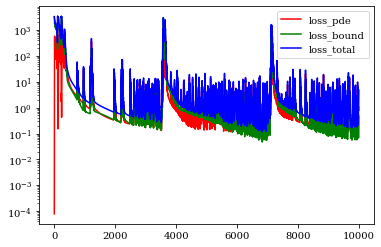

In [ ]:
# train
num_epochs = 10000
lambda_pde = 1.0
lambda_bound = 5.0
log = {"loss_pde" : [],
       "loss_bound" : [],
       "loss_total" : []}
for epoch in range(num_epochs):
    if epoch % 1000 == 0:
        learning_rate *= 0.99

    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate

    net.train()

    upred = net.forward(Xc, Yc)

    loss_bound = boundary_loss_dirichlet_neumann_mixed(
        upred, Xc, Yc, bound_left, bound_right, bound_bottom, bound_slope_top, lambda_bound=lambda_bound)
    loss_pde = pde_loss_poisson(upred, Xc, Yc, f, lambda_pde)
    loss = loss_pde + loss_bound
    log["loss_pde"].append(loss_pde.item())
    log["loss_bound"].append(loss_bound.item())
    log["loss_total"].append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch} --- Loss : {loss}, pde_loss : {loss_pde}, bound_loss : {loss_bound}")

print(loss)
plt.semilogy(log["loss_pde"], 'r', label = 'loss_pde')
plt.semilogy(log["loss_bound"], 'g', label = 'loss_bound')
plt.semilogy(log["loss_total"], 'b', label = 'loss_total')
plt.legend()

In [ ]:
# Saving log file because plotly doesnt work on colab for some reason
import pickle

with open('loss_laplace_rect.pickle', 'wb') as handle:
    pickle.dump(log, handle)

# Compare results

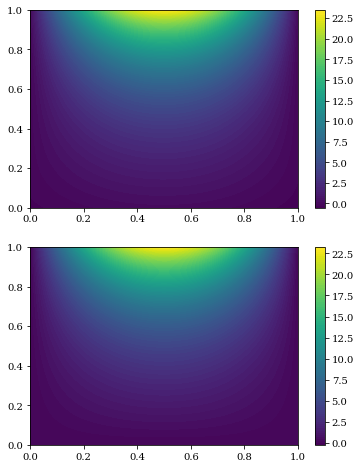

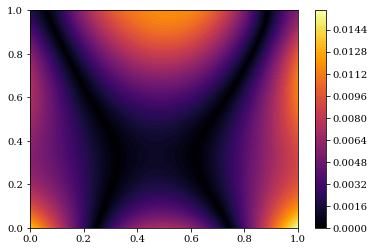

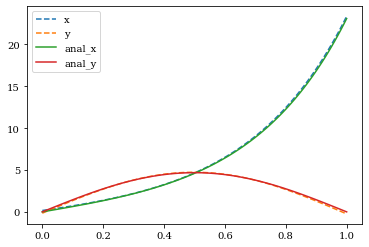

In [ ]:
ana_sol = generate_ana_sol(X, Y)
pinn_sol = net.forward(Xc, Yc)
fig = plt.figure(figsize=(6,8))
ax1 = plt.subplot(211)
cntr1 = ax1.contourf(*plot(X[:, :, 0], Y[:, :, 0], pinn_sol[:, :, 0]), levels=100)
fig.colorbar(cntr1, ax=ax1)
ax2 = plt.subplot(212)
cntr2 = ax2.contourf(*plot(X[:, :, 0], Y[:, :, 0], ana_sol[:, :, 0]), levels=100)
fig.colorbar(cntr2, ax=ax2)

plt.figure()
error = torch.abs(pinn_sol - ana_sol) / torch.max(torch.abs(pinn_sol))
plt.contourf(*plot(X[:,:,0], Y[:,:,0], (error[:,:,0]) + 1e-12), cmap="inferno", levels=100)
plt.colorbar()

plt.figure()
plt.plot(*plot(x, pinn_sol[gridsize // 2, :, 0]), '--', label="x")
plt.plot(*plot(x, pinn_sol[:, gridsize // 2, 0]), '--', label="y")
plt.plot(*plot(x, ana_sol[gridsize // 2, :, 0]), label="anal_x")
plt.plot(*plot(x, ana_sol[:, gridsize // 2, 0]), label="anal_y")
plt.legend()

# Generate solution and error contours

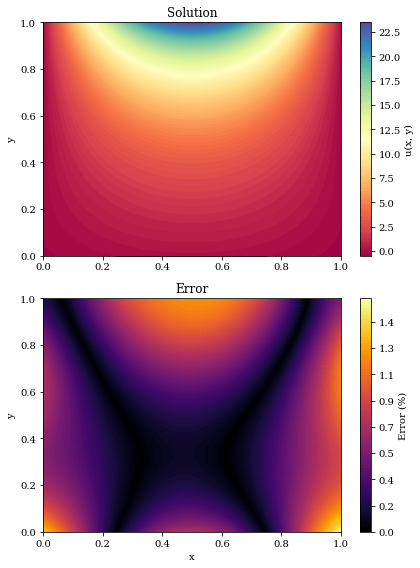

In [ ]:
ana_sol = generate_ana_sol(X, Y)
pinn_sol = net.forward(Xc, Yc)
error = torch.abs(pinn_sol - ana_sol) / torch.max(torch.abs(ana_sol)) * 100.0

import numpy.linalg as la
error_l2 = la.norm((error / 100.0).cpu().detach().numpy()) / np.sqrt(gridsize * gridsize)

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

import matplotlib.ticker as ticker
# specify your own formatter for colorbar labels in return select desired format
def myfmt(x, pos):
    return '{0:.1f}'.format(x)

fig = plt.figure(figsize=(6,8))
ax1 = plt.subplot(211)
cntr1 = ax1.contourf(*plot(X[:, :, 0], Y[:, :, 0], pinn_sol[:, :, 0]), cmap="Spectral", levels=100)
cbar1 = fig.colorbar(cntr1, ax=ax1, label='u(x, y)', format=ticker.FuncFormatter(myfmt))
# ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Solution')
# This is the fix for the white lines between contour levels
for c in cntr1.collections:
    c.set_edgecolor("face")

ax2 = plt.subplot(212)
cntr2 = ax2.contourf(*plot(X[:,:,0], Y[:,:,0], (error[:,:,0]) + 1e-12), cmap="inferno", levels=100)
cbar2 = fig.colorbar(cntr2, ax=ax2, label='Error (%)', format=ticker.FuncFormatter(myfmt))
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('Error')
for c in cntr2.collections:
    c.set_edgecolor("face")

plt.tight_layout()


In [ ]:
error_l2

0.005237871408462524

In [ ]:
fig.savefig('laplace_2d_rect.eps', dpi=300)